In [1]:
import os
import pickle
import torch
import sys

from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tabulate import tabulate

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# fix the path
original_path = os.getcwd()
sys.path.append(os.path.join('.', '..'))
sys.path.append('/content/drive/My Drive/Deep_Learning_Project12/')
os.chdir(sys.path[-1])

Mounted at /content/drive


# Upsampling class (NaturalImageDataSet)


In [3]:
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class NaturalImageDataset(Dataset):
  def __init__(self, data, augment = False, load_img=True, dictator="features_label"):

    # dictator = 'features_label'    # What variable we use to upsample to match
    # upsample if augment
    if augment:
      sample_count = {}
      up_sampler = np.unique(data[dictator])
      for f in up_sampler:
          sample_count[f] = np.count_nonzero(data[dictator] == f)

      maxcount = np.max(list(sample_count.values()))
      for f in up_sampler:
          gapnum = maxcount - sample_count[f]
          temp_df = data.iloc[np.random.choice(np.where(data[dictator] == f)[0], size = gapnum)]
          data = data.append(temp_df, ignore_index = True)
      

    self.dataframe = data
    self.imgage_path = data["image_path"].values
    self.labels = data["ts"].values
    self.features = data["features"].values

    # transform image
    if augment:
      self.transform = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(p = 0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ColorJitter(brightness = 0.1, contrast = 0.1),
                                  transforms.RandomAffine(degrees = 50, translate = (0.1, 0.1), scale = (0.9, 1.1)),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])
    else:
      self.transform = transforms.Compose([
                                  transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])


    if load_img:
      self.images = [self.transform(Image.open(img_path)) for img_path in tqdm(data["image_path"])]

  def __len__(self):
    return (len(self.images))

  def __getitem__(self, i):
    image = self.images[i]
    label = self.labels[i]
    feature = self.features[i]
    return image, torch.tensor(label, dtype=torch.long), torch.tensor(feature, dtype=torch.long)

# Import Data and Wrangling

In [5]:
import numpy as np
import pandas as pd

data_files = os.listdir("Files")
  
labels = pd.read_csv("Files/dermx_labels.csv")
labels["area"] = labels["area"].fillna(value = "NA")
labels = pd.get_dummies(labels, columns = ["area"])
labels["image_path"] = [os.path.join(os.getcwd(),"Files", "images", f"{x}.jpeg") for x in labels["image_id"]]
labels.drop(columns = "Unnamed: 0", inplace = True)
labels["open_comedo"] = (labels["open_comedo"] > 0).astype(int)

features_target = pd.read_csv("Files/diseases_characteristics.csv")
features_target.rename(columns={"Unnamed: 0":"disease"},inplace=True)

# create on_hot for diagnosis and get features
one_hot = pd.get_dummies(labels["diagnosis"])
one_hot_encoding = [list(x) for x in one_hot.values]

labels["ts"] = one_hot_encoding

# get features as multi hot
features_touse = labels.columns[2:14]
labels["features"] = labels.loc[:, features_touse].values.tolist()

# map feature sequences to value
features_map = {}
for idx, feat in enumerate(labels["features"].apply(tuple).unique()):
  features_map[str(feat)] = idx

labels["features_label"] = labels["features"].apply(tuple).apply(str).map(features_map)


# get domain
domain = pd.read_csv("Files/diseases_characteristics.csv")
domain.rename(columns={"Unnamed: 0":"diagnosis"},inplace=True)
domain["area_NA"] = 0 # Fix for area_NA
domain = pd.get_dummies(domain, columns = ["area"])
same_sort = labels.columns[1:14]
domain = domain[same_sort]  # same sorting

domain_one_hot = pd.get_dummies(domain["diagnosis"])

domain_one_hot_encoding = [list(x) for x in domain_one_hot.values]
domain["ts"] = domain_one_hot_encoding
feature_cols = domain.columns[1:13]
domain["features"] = domain.loc[:,feature_cols].values.tolist()

# add domain features (domain knowledge) to dataframe
tf = []
for i, row in labels.iterrows():
  disease = row["diagnosis"]
  true_features = domain.loc[domain.diagnosis == disease].features.tolist()[0]
  tf.append(true_features)
labels["domain_features"] = tf 

domain = domain.sort_values(by="diagnosis").reset_index(drop=True)

data = labels.copy()
up_data = NaturalImageDataset(data,augment=True,load_img=False)
upsampled_data = up_data.dataframe

In [6]:
def add_domain(df: pd.DataFrame):
  domain = pd.read_csv("Files/diseases_characteristics.csv")
  domain.rename(columns={"Unnamed: 0":"diagnosis"},inplace=True)
  domain["area_NA"] = 0 # Fix for area_NA
  domain = pd.get_dummies(domain, columns = ["area"])
  same_sort = df.columns[1:14]
  domain = domain[same_sort]  # same sorting

  domain_one_hot = pd.get_dummies(domain["diagnosis"])

  domain_one_hot_encoding = [list(x) for x in domain_one_hot.values]
  domain["ts"] = domain_one_hot_encoding
  feature_cols = domain.columns[1:13]
  domain["features"] = domain.loc[:,feature_cols].values.tolist()

  # add domain features (domain knowledge) to dataframe
  tf = []
  for i, row in df.iterrows():
    disease = row["diagnosis"]
    true_features = domain.loc[domain.diagnosis == disease].features.tolist()[0]
    tf.append(true_features)
  df["domain_features"] = tf 

  return df

# colors

In [7]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

cmap = [matplotlib.colors.to_rgb(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

# Plot datset distribution

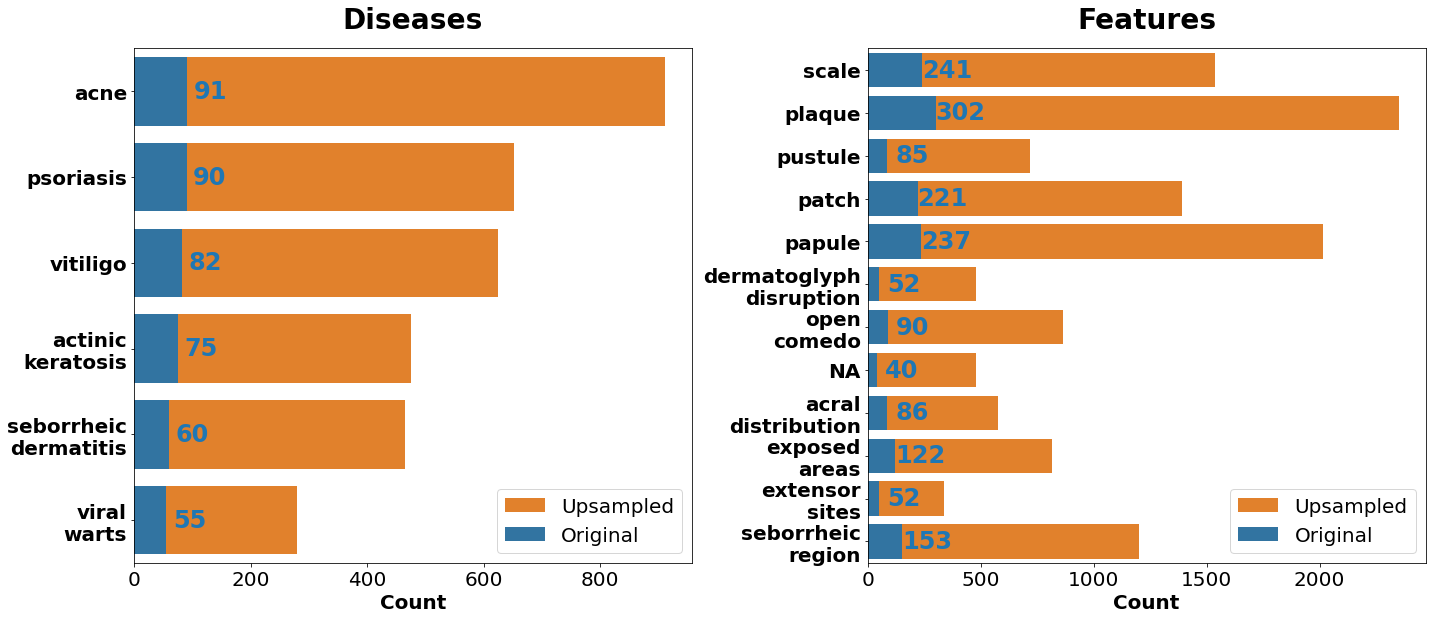

In [8]:
def fix_label(label: str):
  if "area_" in label:
    label = label.replace("area_","")
  new_str = label.replace("_","\n")
  return new_str

fig=plt.figure(figsize=(20,16))

# labels = labels.iloc[runs[3].train_idx]
# upsampled_data = NaturalImageDataset(labels,True,False)
# upsampled_data = upsampled_data.dataframe

# Diagnosis
up_count = upsampled_data.diagnosis.value_counts()
org_count = labels.diagnosis.value_counts()
org_ytick_lab = [fix_label(x) for x in org_count.keys()]
up_ytick_lab = [fix_label(x) for x in up_count.keys()] 

header_size = 28
text_size = 20
tip_size = 24
legend_size = 20
xtick_size = 20

plt.subplot(2,2,1)
up=sns.barplot(y=up_ytick_lab, x=up_count,color=cmap[1],label="Upsampled")
org=sns.barplot(y=org_ytick_lab, x=org_count,color=cmap[0],label="Original")
plt.legend(loc="lower right",prop={"size": legend_size},fontsize=text_size)
org.set_yticklabels(org.get_yticklabels(),fontsize=text_size,weight="bold")
plt.title("Diseases",fontsize=header_size,weight="bold",pad=20)
plt.xlabel("Count",fontsize=text_size,weight="bold")
# add value to barplot
for i, val in enumerate(np.array(org_count)):
    org.text(val+40, i, str(val), color=cmap[0],
             ha="center",  va="center",
             fontsize=tip_size, weight="bold")
    # val=up_count[i]
    # up.text(val+10, i, str(val), color=cmap[1], ha="center", va="center",
    #        rotation=-90, fontsize=14, weight="bold")

# adjust ticks
fig.canvas.draw()
org.set_xticklabels(up.get_xticklabels(),fontsize=xtick_size)

# Features
ytick_lab = [fix_label(x) for x in features_touse.to_list()]
up_count = np.array(upsampled_data.loc[:,features_touse].sum())
org_count = np.array(labels.loc[:,features_touse].sum())

plt.subplot(2,2,2)
up=sns.barplot(y=ytick_lab, x=up_count,color=cmap[1],label="Upsampled")
org=sns.barplot(y=ytick_lab, x=org_count,color=cmap[0],label="Original")
plt.legend(loc="lower right",prop={"size": legend_size},fontsize=text_size)
org.set_yticklabels(org.get_yticklabels(),fontsize=text_size,weight="bold",)
plt.title("Features",fontsize=header_size,weight="bold",pad=20)
plt.xlabel("Count",fontsize=text_size,weight="bold")

# add value to barplot
for i, val in enumerate(np.array(org_count)):
    org.text(val+110, i, str(val), color=cmap[0],
             ha="center",  va="center",
             fontsize=tip_size, weight="bold")
    # val=up_count[i]
    # up.text(val+20, i, str(val), color=cmap[1], ha="center", va="center",
    #        rotation=-90, fontsize=14, weight="bold")

# adjust ticks
fig.canvas.draw()
org.set_xticklabels(up.get_xticklabels(),fontsize=xtick_size)


fig.tight_layout()

# _save = input("Want to overwrite Dataset_Distributions.eps?: ")
# if _save == "yes":
#   plt.savefig("Figures/Dataset_Distributions.eps",format="eps",dpi=1000)

In [40]:
dist=labels.loc[:,features_touse].sum()
sdist = dist.iloc[np.argsort(dist, order="descending").values]
sdist = sdist.sort_values(ascending=False)
sdist

plaque                     302
scale                      241
papule                     237
patch                      221
area_seborrheic_region     153
area_exposed_areas         122
open_comedo                 90
area_acral_distribution     86
pustule                     85
area_extensor_sites         52
dermatoglyph_disruption     52
area_NA                     40
dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


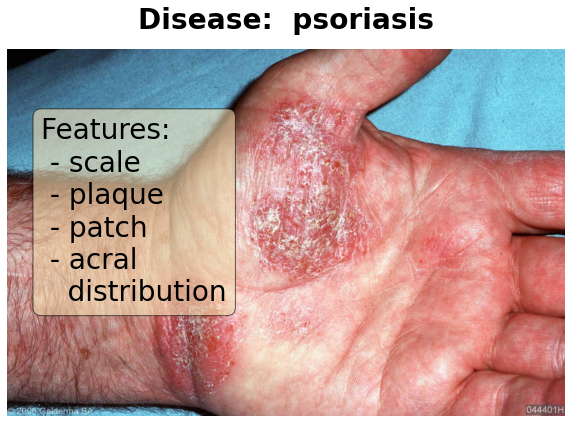

In [ ]:
demo_id = "044401HB"
demo = labels.loc[labels.image_id==demo_id]
im = imread(demo.image_path.values[0])

fig,ax=plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(7)

plt.imshow(im)
plt.axis("on")
plt.title(f"Disease:  {demo.diagnosis.values[0]}", fontsize=28, weight="bold",
          pad=20)

def fix_label2(label: str):
  if "area_" in label:
    label = label.replace("area_","")
  new_str = label.replace("_","\n   ") # HARDCODED FOR DEMO FIGURE
  return new_str

table_df = pd.DataFrame()
feature_labels = [fix_label2(x) for x in features_touse.to_list()]
on = np.where(np.array(demo.features.to_list()[0],dtype=int)==1)[0].tolist()
flab = [feature_labels[x] for x in on]
flab = '\n - '.join(flab)
txtstr = f"Features: \n - "+ flab  
props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
plt.axis("off")
plt.text(100, 200, txtstr, fontsize=28,
        verticalalignment='top', bbox=props)

plt.savefig("Figures/DiseaseExample.eps",format="eps",dpi=100)

In [ ]:
#@title Old plot
# plt.figure(figsize = (10,7))

# plt.subplot(3,1,1)#upsampled_data.loc[:,features_touse].sum().plot(kind = "bar")
# labels.loc[:,features_touse].sum().plot(kind = "bar")
# plt.xticks(rotation=15)
# plt.ylabel("Count")
# plt.title("Frequency of each feature")

# plt.subplot(3,1,2)
# #upsampled_data["diagnosis"].value_counts(sort=True).plot(kind = "bar")
# labels["diagnosis"].value_counts(sort=True).plot(kind = "bar")
# plt.ylabel("Count")
# plt.xticks(rotation=15)
# plt.title("Distribution of diagnosis")


# plt.subplot(3,1,3)
# #upsampled_data['features_label'].hist(bins = np.unique(upsampled_data['features_label'])  - 0.5)
# labels['features_label'].hist(bins = np.unique(labels['features_label']) - 0.5)
# plt.ylabel("Count")
# plt.xlabel("Feature sequence label")
# plt.title("Distribution of feature combinations")


# plt.tight_layout()
# plt.show()

In [ ]:
#@title Some helpful functions
from HelperFunctions.project_utils import Tracker
from sklearn.utils import class_weight


def add_no_match(df: pd.DataFrame):
  
  unique_data = [list(x) for x in set(tuple(x) for x in df.domain_features)]

  app = []
  for i, row in df.iterrows():
    for x in unique_data:
      tmp_row = row.copy()
      if tmp_row["domain_features"] == x:
        pass
      else:
        tmp_row["diagnosis"] = "no_match"
        tmp_row["domain_features"] = x
        app.append(tmp_row)

  # Create new data frame
  updated_df=df.append(app,ignore_index=True)
  
  # Update targets "ts"
  updated_df.drop(columns="ts")
  new_dummies = pd.get_dummies(updated_df["diagnosis"])
  new_dummies = [list(x) for x in new_dummies.values]
  updated_df["ts"] = new_dummies

  return updated_df

def unique_lists(data: list):
  return [list(x) for x in set(tuple(x) for x in data)]

def map_domain_knowledge(df: pd.DataFrame):
  keys = df.diagnosis.unique().tolist()
  map = dict()
  for k in keys:
    map[k] = df.loc[data["diagnosis"] == k].domain_features.tolist()[0]
  return map

def plt_tracker(tracker: Tracker, num_epoch):
    plt.figure(figsize=(14,8))
    epoch_ticks = range(0,num_epoch + 1, 5)

    # loss
    plt.subplot(1,2,1)
    plt.plot(tracker.train_iter, tracker.train_loss, label='Training loss')
    plt.plot(tracker.val_iter, tracker.val_loss, label='Validation loss')
    plt.title("Loss")
    plt.ylabel("Loss"), plt.xlabel("Epoch")
    plt.xticks(epoch_ticks)
    plt.legend()
    plt.grid()

    # acc
    plt.subplot(1,2,2)
    plt.plot(tracker.train_iter, tracker.train_acc, label='Training accuracy')
    plt.plot(tracker.val_iter, tracker.val_acc, label='Validation accuracy')
    plt.title("Accuracy")
    plt.ylabel("Accuracy"), plt.xlabel("Epoch")
    plt.xticks(epoch_ticks)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def calc_multiclass_weights(df: pd.DataFrame, device):
  
  cls = sorted(df.diagnosis.unique())
  y = df.diagnosis.to_list()
  csw = class_weight.compute_class_weight('balanced', classes = cls, y = y)
  class_weights = torch.tensor(csw,dtype=torch.float).to(device)

  return class_weights

def feature_intersect(domain, features):
    dom_feat = np.asarray(domain)
    curr_feat = np.asarray(features)
    
    ones=np.intersect1d(np.where(dom_feat==1), np.where(curr_feat==1))
    intersect = np.zeros(len(dom_feat),dtype=int)
    intersect[ones] = 1

    return intersect


# Summarize LabelsNet k_fold



In [ ]:
from HelperFunctions.project_utils import KFoldResult, plot_tracker
from sklearn.metrics import classification_report

runs = []
k = 5
for i in range(k):
  fname=f"K_fold/MTLNet_FINAL_kfold_{i}.json"
  run = KFoldResult(fname,isMTL=False)
  runs.append(run)

labels_acc = np.zeros(len(runs))
features_acc = np.zeros(len(runs))
for i, run in enumerate(runs):

  labels_acc[i], features_acc[i] = run.get_accuracy()


tab_df = pd.DataFrame()
tab_df["labels"] = labels_acc
tab_df["features"] = features_acc
tab=tabulate(tab_df,
             headers={"Labels F1-score",
                      "Features F1-score"},
             floatfmt=".3f")
print(tab)
print("="*50)
print(f"Mean [SD]:\t{labels_acc.mean():.3f} [{labels_acc.std():.3f}]"+
      f"        {features_acc.mean():.3f} [{features_acc.std():.3f}]")


from sklearn.metrics import confusion_matrix

def plot_conf(conf,target_labels):
  df_cm = pd.DataFrame(conf, index = [i for i in target_labels],
                              columns = [i for i in target_labels])
  plt.figure(figsize = (7,4))
  sns.heatmap(df_cm, annot=True, cmap="Blues")
  plt.show()

num_classes = len(np.unique(run.labels_targets))
overall_conf = np.zeros(shape=(num_classes, num_classes, len(runs)))
for i, run in enumerate(runs):
  conf = confusion_matrix(run.labels_targets, run.labels_preds, normalize="true")
  #plot_conf(conf,sorted(data.diagnosis.unique().tolist()))
  #print(classification_report(run.labels_targets, run.labels_preds))
  overall_conf[:,:,i] = conf

plot_conf(overall_conf.mean(axis=2), sorted(data.diagnosis.unique().tolist()))


In [ ]:
from HelperFunctions.project_utils import KFoldResult, plot_tracker
from sklearn.metrics import classification_report

runs = []
k = 5
for i in range(k):
  fname=f"K_fold/LabelsNet_FINAL_kfold_{i}.json"
  run = KFoldResult(fname,isMTL=False)
  runs.append(run)

labels_acc = np.zeros(len(runs))
for i, run in enumerate(runs):

  labels_acc[i] = run.get_labels_accuracy()


tab_df = pd.DataFrame()
tab_df["labels"] = labels_acc
tab=tabulate(tab_df,
             headers={"Labels F1-score"},
             floatfmt=".3f")
print(tab)
print("="*50)
print(f"Mean [SD]:\t{labels_acc.mean():.3f} [{labels_acc.std():.3f}]")
      #f"        {features_acc.mean():.3f} [{features_acc.std():.3f}]")


from sklearn.metrics import confusion_matrix

def plot_conf(conf,target_labels):
  df_cm = pd.DataFrame(conf, index = [i for i in target_labels],
                              columns = [i for i in target_labels])
  plt.figure(figsize = (7,4))
  sns.heatmap(df_cm, annot=True, cmap="Blues")
  plt.show()

num_classes = len(np.unique(run.labels_targets))
overall_conf = np.zeros(shape=(num_classes, num_classes, len(runs)))
for i, run in enumerate(runs):
  conf = confusion_matrix(run.labels_targets, run.labels_preds, normalize="true")
  #plot_conf(conf,sorted(data.diagnosis.unique().tolist()))
  #print(classification_report(run.labels_targets, run.labels_preds))
  overall_conf[:,:,i] = conf

plot_conf(overall_conf.mean(axis=2), sorted(data.diagnosis.unique().tolist()))


In [ ]:
from HelperFunctions.project_utils import KFoldResult, plot_tracker
from sklearn.metrics import classification_report

runs = []
k = 5
for i in range(k):
  fname=f"K_fold/Features_FINAL_kfold_{i}.json"
  run = KFoldResult(fname,isMTL=False)
  runs.append(run)

features_acc = np.zeros(len(runs))
for i, run in enumerate(runs):

  features_acc[i] = run.get_features_accuracy()


tab_df = pd.DataFrame()
tab_df["features"] = features_acc
tab=tabulate(tab_df,
             headers={"Features F1-score"},
             floatfmt=".3f")
print(tab)
print("="*50)
print(f"Mean [SD]:\t{features_acc.mean():.3f} [{features_acc.std():.3f}]")
      #f"        {features_acc.mean():.3f} [{features_acc.std():.3f}]")



